In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys, os

import tensorflow as tf
from tensorflow.keras import layers, Model

In [16]:
from keras.datasets import mnist,cifar10

(imgs, _), (test, _) = mnist.load_data()

In [17]:
sample = np.random.randint(0,len(imgs),4)

sample = imgs[sample,:,:]

(60000, 28, 28)


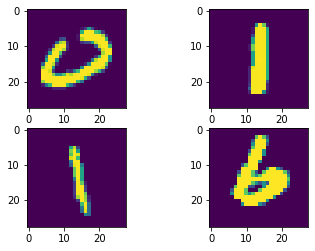

In [18]:
rows = 2
cols = 2
fig = plt.figure()
print(imgs.shape)
for idx, img in enumerate(sample):
    ax = fig.add_subplot(rows, cols, idx+1)
    ax.imshow(img)

plt.show()

In [19]:
batch = 1024
buffer = 60000
img_shape = imgs.shape[1:]
d_set = tf.data.Dataset.from_tensor_slices(imgs)
d_set = d_set.shuffle(buffer).batch(batch,drop_remainder=True)
# d_set = d_set.map(lambda x: tf.reshape(x,[batch,-1]))

for x in d_set.take(1):
    print(x.shape)

(1024, 28, 28)


In [20]:
def generator(input_dim, img_shape):
    nums = 1
    for x in img_shape:
        nums = nums*x
    inputs = layers.Input(shape = (input_dim,))
    x = layers.Dense(128)(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # x = layers.Dense(512)(x)
    # x = layers.LeakyReLU(alpha=0.2)(x)

    # x = layers.Dense(1024)(x)
    # x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Dense(nums)(x)
    out = layers.Reshape(img_shape)(x)
    
    model = Model(inputs=inputs, outputs=out,name='Generator')
    return model

In [21]:
def discriminator(img_shape):
    inputs = layers.Input(shape = img_shape)
    x = layers.Flatten()(inputs)

    # x = layers.Dense(1024)(x)
    # x = layers.LeakyReLU(alpha=0.2)(x)
    
    # x = layers.Dense(512)(x)
    # x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Dense(128)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Dense(32)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.LeakyReLU(alpha=0.2)(x)

    out = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=out, name='Discriminator')
    return model

In [22]:
noise_dim = 100
x = np.random.uniform(-1, 1, size=[batch, noise_dim])

g = generator(noise_dim,img_shape)
d = discriminator(img_shape)

In [23]:
g.summary()
d.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_7 (Dense)             (None, 128)               12928     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               33024     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 784)               201488    
                                                                 
 reshape_1 (Reshape)         (None, 28, 28)            0 

In [24]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def d_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def g_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

g_opt = tf.optimizers.Adam(0.0002, 0.5)
d_opt = tf.optimizers.Adam(0.0002, 0.5)

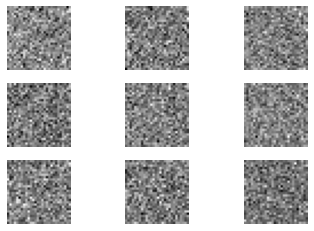

In [25]:
def generating_img_plot(g,sample = None):
    if sample == None:
        x = np.random.uniform(-1, 1, size=[9, noise_dim])
    else:
        x = sample
    imgs = g(x).numpy()
    rows = 3
    cols = 3
    fig = plt.figure()

    for idx, img in enumerate(imgs):
        img = (np.max(img) - img) / (np.max(img) - np.min(img))
        ax = fig.add_subplot(rows, cols, idx+1)
        if img.shape[-1] != 3:
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(img)

        ax.axis('off')
    plt.show()

generating_img_plot(g)

In [26]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = g(noise, training=True)

      real_output = d(images, training=True)
      fake_output = d(generated_images, training=True)

      gen_loss = g_loss(fake_output)
      disc_loss = d_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, g.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, d.trainable_variables)

    g_opt.apply_gradients(zip(gradients_of_generator, g.trainable_variables))
    d_opt.apply_gradients(zip(gradients_of_discriminator, d.trainable_variables))
    return gen_loss,disc_loss

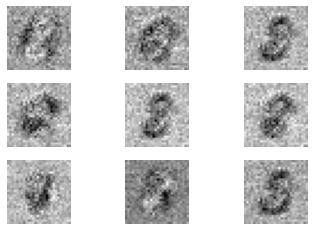

99epoch, 57batch | G_loss: 0.0899, D_loss: 6.0921


In [27]:
from IPython import display
from collections import defaultdict

hist = defaultdict(list)
for epoch in range(100):
    d_losses = []
    g_losses = []
    for idx, image_batch in enumerate(d_set):
        d_loss,g_loss = train_step(image_batch)
        display.clear_output(wait=True)
        generating_img_plot(g)
        d_losses.append(d_loss.numpy())
        g_losses.append(g_loss.numpy())
        print('{}epoch, {}batch | G_loss: {:.4f}, D_loss: {:.4f}'.format(epoch,idx,g_losses[-1],d_losses[-1]))
    g_losses = np.mean(g_losses)
    d_losses = np.mean(d_losses)
    hist['g_loss'].append(g_losses)
    hist['d_loss'].append(d_losses)

In [28]:
116*512

59392